In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise, Statistics


┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260


In [2]:

batch = 1001


# files = readdir(datadir("img"))

files = [
    	"Iine_gap_1_100_gs.png",
     "Iine_gap_2_100_gs.png",
     "Iine_gap_3_100_gs.png",
     "Iine_gap_4_100_gs.png",
     "Iines_gaps_100_gs.png",
     "diag_dots_100_gs.png",
     "diag_gap_100_gs.png",
     "kan_sq_cont.png",
     "kan_sq_cont_l.png",
     "mo05709.png",
     "stairs_100gs.png",
     "stairs_200gs.png",
    "viper00187.png",
    "viper00661.jpg",
    "viper00715.png",
    "viper00717.png",
    "viper00720.png",
    "viper00721.png",
    "viper00842.jpg",
    "viper00891.jpg",
    "viper00904.jpg",
    "viper00921.jpg",
    "viper01006.jpg",
    "viper01333.jpg",
]

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("illusions", batch_)))

tspan = (0.0f0, 800f0)

# for file in files
#     try
file = files[1]
        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("img", file),
            Parameters.parameters_f32,
        )

        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(@view u0[:, :, 1:2, :])
        arr2 = similar(@view u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
        # 	@benchmark sol = solve(prob)
        sol = solve(prob)


┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 769-element Array{Float32,1}:
   0.0
   1.0f-6
   8.486125f-6
   6.001479f-5
   0.0003142698
   0.0014011806
   0.0048673684
   0.015721392
   0.044997014
   0.09827553
   0.16523026
   0.24867454
   0.41559318
   ⋮
 789.264
 790.32117
 791.37836
 792.4356
 793.49286
 794.5501
 795.60736
 796.6646
 797.7218
 798.779
 799.8362
 800.0
u: 769-element Array{CuArray{Float32,4},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.

In [31]:
Utils.plot_t_act_mean(sol, "illusions", batch_, file, save=false)

InterruptException: InterruptException:

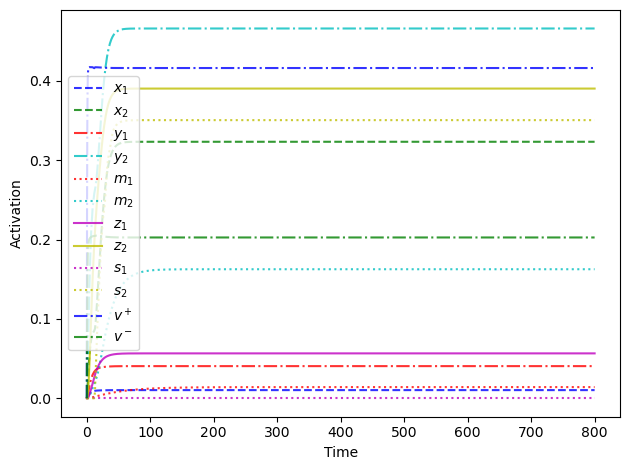

In [33]:
Utils.plot_t_act(sol, "illusions", batch_, file, save=false)

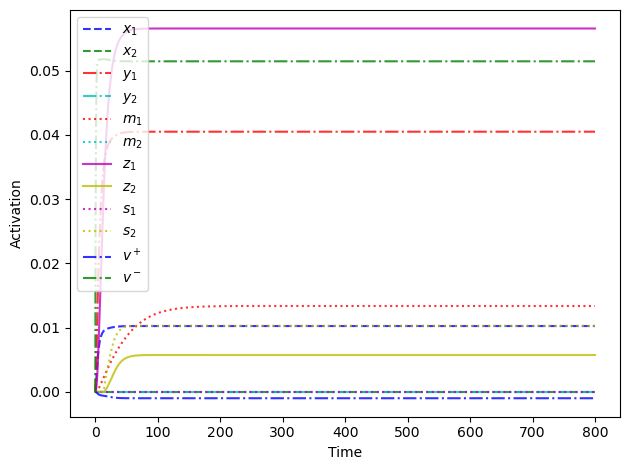

In [32]:
Utils.plot_t_act_px(sol, "illusions", batch_, file, save=false)

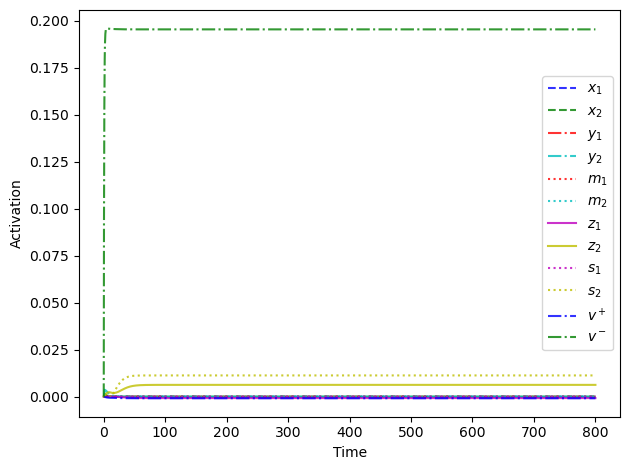

In [36]:
Utils.plot_t_act_spec(sol, "illusions", batch_, file, save=false)

In [15]:
size(sol, 5)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/Utils.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/Utils.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820


769

In [30]:
name = "illusions"
save=false
# function plot_t_act_mean(sol, name, batch, file; save = true)
    fig, axs = plt.subplots()
    @inbounds begin
        for k ∈ 1:12
            # v1 = @view sol[:, :, k, 1, end]
            # v2 = @view sol[findmax(v1)[2][1], findmax(v1)[2][2], k, 1, :]
            v2 = []
				for s in 1:size(sol, 5)
					push!(v2,mean(@view sol[:,:, k, 1, s]))
                end
				layer = Utils.layers_1[k]
				axs.plot(sol.t, v2, Utils.lines[k], label = "$layer", alpha = 0.8)
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.legend()
        fig.tight_layout()
        if save
            plt.savefig(plotsdir(
                string(name, batch),
                string(file, "_time.png"),
            ))
        end
        close("all")
    end
#     return nothing
# end

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /mnt/storage_1/users/cullinanen/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (769,) and (1,)')
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1647, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 216, in __call__
    yield from self._plot_args(this, kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 342, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


In [29]:
v2

769-element Array{Any,1}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
   ⋮
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [35]:
k=1
			v2 = Array{eltype(float32)}(undef, size(sol, 5))
			for s in 1:size(sol, 5)
				v2[s] = mean(@view sol[:,:, k, 1, s])
			end

InterruptException: InterruptException: